In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import pandas as pd
from pandas_datareader import data
from pandas_datareader._utils import RemoteDataError
from datetime import timedelta
import datetime

# Please read, my idea was to classify the data into three cateogries: "UP", "DOWN", "NEUTRAL"
# UP - the price of the stock is up MINIMUM_GAIN percent after LOOK_AHEAD_DAYS days.
# DOWN - the price of the stock is down MINIMUM_GAIN percent after LOOK_AHEAD_DAYS days.
# NEUTRAL - the price of stock is did not rise or fall past the MINIMUM_GAIN threshhold
#
# EXAMPLE: LOOK_AHEAD_DAYS = 30, MINIMUM_GAIN = .05 (5%). If stock is up over 5% ore more after 30 days, 
# we mark it as 'UP'. If the stock is down 5% or more after 30 days, we mark it as 'DOWN'. If the stock
# is neither up nor down 5%, then we mark it as 'NEUTRAL'

# MINIMUM_GAIN = .05 #minimal gain to be considered up or down for classification, UNUSED NOW

LOOK_BACK_DAYS = 30 #number of days into the past we would like to take into account
LOOK_AHEAD_DAYS = 1 #number of days into the future we are trying to predict

class Utilities:

    @staticmethod
    def getData(ticker, start_date, end_date):
        try:
            stock_data = data.DataReader(ticker,
                                         'yahoo',
                                         start_date,
                                         end_date)
            return stock_data
        except RemoteDataError:
            print('No data found for {t}'.format(t=ticker))
#just get the btc price points from the past year
start_date = datetime.datetime.now() - timedelta(365)
end_date = datetime.datetime.now() - timedelta(1)
btc_df = Utilities.getData('BTC-USD', str(start_date.strftime('%Y-%m-%d')), str(end_date.strftime('%Y-%m-%d')))
btc_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-14,10437.411133,9675.316406,10038.421875,10311.545898,2.289912e+10,10311.545898
2019-08-15,10524.349609,9855.478516,10319.419922,10374.338867,2.022821e+10,10374.338867
2019-08-16,10452.625000,10086.698242,10358.722656,10231.744141,1.377804e+10,10231.744141
2019-08-17,10487.070312,10119.094727,10233.005859,10345.810547,1.299981e+10,10345.810547
2019-08-18,10916.053711,10313.204102,10350.283203,10916.053711,1.603826e+10,10916.053711
...,...,...,...,...,...,...
2020-08-09,12045.140625,11662.256836,11662.256836,11878.111328,2.611411e+10,11878.111328
2020-08-10,11932.710938,11195.708984,11881.647461,11410.525391,2.703978e+10,11410.525391
2020-08-11,11748.396484,11249.605469,11404.596680,11584.934570,2.506455e+10,11584.934570


In [3]:
def createLookBackCols():
    for i in range(LOOK_BACK_DAYS):
        num_rows= btc_df.shape[0]
        num_cols= btc_df.shape[1]
        btc_df.insert(loc = num_cols, column = 'High_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Low_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Open_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Close_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Volume_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Adj Close_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        
createLookBackCols() #create additional look back columns
btc_df = btc_df.loc[~btc_df.index.duplicated(keep='first')] #delete all duplicate indices

for index, row in btc_df.iterrows():
    current_date = index.to_pydatetime()
    if (current_date - start_date).days >= LOOK_BACK_DAYS - 1:
        for i in range(LOOK_BACK_DAYS):
            index = i + 1
            look_back_date = current_date - timedelta(days=index)
            
            while True: #we need to keep subtracting days to the look_back_date because there is no index for that day
                if look_back_date in btc_df.index:
                    break
                look_back_date = look_back_date - timedelta(days=1)
            
            btc_df.at[pd.Timestamp(current_date), 'High_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'High']
            btc_df.at[pd.Timestamp(current_date), 'Low_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Low']
            btc_df.at[pd.Timestamp(current_date), 'Open_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Open']
            btc_df.at[pd.Timestamp(current_date), 'Close_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Close']
            btc_df.at[pd.Timestamp(current_date), 'Volume_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Volume']
            btc_df.at[pd.Timestamp(current_date), 'Adj Close_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Adj Close']

btc_df = btc_df[btc_df.High_Past_1 != 'N/A']
btc_df

,High,Low,Open,Close,Volume,Adj Close,Adj Close_Past_1,Volume_Past_1,Close_Past_1,Open_Past_1,...,Close_Past_29,Open_Past_29,Low_Past_29,High_Past_29,Adj Close_Past_30,Volume_Past_30,Close_Past_30,Open_Past_30,Low_Past_30,High_Past_30
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-14,10387.035156,10313.092773,10356.465820,10347.712891,1.204343e+10,10347.712891,10358,1.34687e+10,10358,10345.4,...,10231.7,10358.7,10086.7,10452.6,10374.3,2.02282e+10,10374.3,10319.4,9855.48,10524.3
2019-09-15,10386.867188,10189.744141,10347.222656,10276.793945,1.516017e+10,10276.793945,10347.7,1.20434e+10,10347.7,10356.5,...,10345.8,10233,10119.1,10487.1,10231.7,1.3778e+10,10231.7,10358.7,10086.7,10452.6
2019-09-16,10296.771484,10199.739258,10281.513672,10241.272461,1.530460e+10,10241.272461,10276.8,1.51602e+10,10276.8,10347.2,...,10916.1,10350.3,10313.2,10916.1,10345.8,1.29998e+10,10345.8,10233,10119.1,10487.1
2019-09-17,10275.928711,10191.469727,10247.795898,10198.248047,1.616927e+10,10198.248047,10241.3,1.53046e+10,10241.3,10281.5,...,10763.2,10916.3,10619,10947,10916.1,1.60383e+10,10916.1,10350.3,10313.2,10916.1
2019-09-18,10295.668945,9851.692383,10200.496094,10266.415039,1.993769e+10,10266.415039,10198.2,1.61693e+10,10198.2,10247.8,...,10138,10764.6,9962.72,10798.7,10763.2,1.50531e+10,10763.2,10916.3,10619,10947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-09,12045.140625,11662.256836,11662.256836,11878.111328,2.611411e+10,11878.111328,11675.7,1.74896e+10,11675.7,11737.3,...,9276.5,9241.05,9197.45,9319.42,9240.35,1.32499e+10,9240.35,9277.51,9199.49,9293.53
2020-08-10,11932.710938,11195.708984,11881.647461,11410.525391,2.703978e+10,11410.525391,11878.1,2.61141e+10,11878.1,11662.3,...,9243.61,9277.21,9224.29,9306.41,9276.5,1.44524e+10,9276.5,9241.05,9197.45,9319.42
2020-08-11,11748.396484,11249.605469,11404.596680,11584.934570,2.506455e+10,11584.934570,11410.5,2.70398e+10,11410.5,11881.6,...,9243.21,9238.7,9171.66,9283.84,9243.61,1.75198e+10,9243.61,9277.21,9224.29,9306.41


In [4]:
btc_df = btc_df.assign(MonthTrend=lambda x: "N/A") #introduce new column that will be the trend we are predicting
btc_df = btc_df.loc[~btc_df.index.duplicated(keep='first')] #delete all duplicate indices

#Populate the classification column MonthTrend
for index, row in btc_df.iterrows():
    current_date = index.to_pydatetime()
   
    if (end_date - current_date).days > LOOK_AHEAD_DAYS:
        look_ahead_date = current_date + timedelta(days=LOOK_AHEAD_DAYS)
        
        while True: #we need to keep adding days to the look_ahead_date because there is no index for that day
            if look_ahead_date in btc_df.index:
                break
            look_ahead_date = look_ahead_date + timedelta(days=1)
        
        #Here we check if the open price in the future is higher than today's open price.
        if btc_df.loc[pd.Timestamp(look_ahead_date)]['Open'] > btc_df.loc[index]['Open']:
            btc_df.at[pd.Timestamp(look_ahead_date), 'MonthTrend'] = 'UP'
        else:
            btc_df.at[pd.Timestamp(look_ahead_date), 'MonthTrend'] = 'DOWN'
            
#Now delete all columns that have a MonthTrend value of N/A
btc_df = btc_df[btc_df.MonthTrend != 'N/A']

#Data is now fully processed and ready to be trained on the machine learning model
#There are 3 values for MonthTrend: UP, DOWN,NEUTRAL
btc_df

,High,Low,Open,Close,Volume,Adj Close,Adj Close_Past_1,Volume_Past_1,Close_Past_1,Open_Past_1,...,Open_Past_29,Low_Past_29,High_Past_29,Adj Close_Past_30,Volume_Past_30,Close_Past_30,Open_Past_30,Low_Past_30,High_Past_30,MonthTrend
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-15,10386.867188,10189.744141,10347.222656,10276.793945,1.516017e+10,10276.793945,10347.7,1.20434e+10,10347.7,10356.5,...,10233,10119.1,10487.1,10231.7,1.3778e+10,10231.7,10358.7,10086.7,10452.6,DOWN
2019-09-16,10296.771484,10199.739258,10281.513672,10241.272461,1.530460e+10,10241.272461,10276.8,1.51602e+10,10276.8,10347.2,...,10350.3,10313.2,10916.1,10345.8,1.29998e+10,10345.8,10233,10119.1,10487.1,DOWN
2019-09-17,10275.928711,10191.469727,10247.795898,10198.248047,1.616927e+10,10198.248047,10241.3,1.53046e+10,10241.3,10281.5,...,10916.3,10619,10947,10916.1,1.60383e+10,10916.1,10350.3,10313.2,10916.1,DOWN
2019-09-18,10295.668945,9851.692383,10200.496094,10266.415039,1.993769e+10,10266.415039,10198.2,1.61693e+10,10198.2,10247.8,...,10764.6,9962.72,10798.7,10763.2,1.50531e+10,10763.2,10916.3,10619,10947,DOWN
2019-09-19,10285.872070,10132.186523,10266.318359,10181.641602,1.473419e+10,10181.641602,10266.4,1.99377e+10,10266.4,10200.5,...,10142.5,9831.46,10233,10138,1.94731e+10,10138,10764.6,9962.72,10798.7,UP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-08,11806.056641,11548.784180,11737.325195,11675.739258,1.748961e+10,11675.739258,11754,1.75721e+10,11754,11604.6,...,9277.51,9199.49,9293.53,9278.81,1.686e+10,9278.81,9273.36,9118,9287.47,UP
2020-08-09,12045.140625,11662.256836,11662.256836,11878.111328,2.611411e+10,11878.111328,11675.7,1.74896e+10,11675.7,11737.3,...,9241.05,9197.45,9319.42,9240.35,1.32499e+10,9240.35,9277.51,9199.49,9293.53,DOWN
2020-08-10,11932.710938,11195.708984,11881.647461,11410.525391,2.703978e+10,11410.525391,11878.1,2.61141e+10,11878.1,11662.3,...,9277.21,9224.29,9306.41,9276.5,1.44524e+10,9276.5,9241.05,9197.45,9319.42,UP


In [5]:
def generateFeatures(features):
    complete_features = []
    for feature in features:
        complete_features.append(feature)
        for i in range(LOOK_BACK_DAYS):
            complete_features.append(feature + "_Past_" + str(i + 1))
    return complete_features

features = generateFeatures(['Close','Open'])
features.append('MonthTrend')

# selecting the important feature open close
btc = btc_df[features]
btc

,Close,Close_Past_1,Close_Past_2,Close_Past_3,Close_Past_4,Close_Past_5,Close_Past_6,Close_Past_7,Close_Past_8,Close_Past_9,...,Open_Past_22,Open_Past_23,Open_Past_24,Open_Past_25,Open_Past_26,Open_Past_27,Open_Past_28,Open_Past_29,Open_Past_30,MonthTrend
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-15,10276.793945,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,...,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,10358.7,DOWN
2019-09-16,10241.272461,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,...,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,DOWN
2019-09-17,10198.248047,10241.3,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,...,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,DOWN
2019-09-18,10266.415039,10198.2,10241.3,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,...,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,DOWN
2019-09-19,10181.641602,10266.4,10198.2,10241.3,10276.8,10347.7,10358,10360.5,10410.1,10178.4,...,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,UP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-08,11675.739258,11754,11601.5,11779.8,11747,11246.3,11246.3,11053.6,11759.6,11323.5,...,9151.18,9131.81,9191.98,9241.9,9238.7,9277.21,9241.05,9277.51,9273.36,UP
2020-08-09,11878.111328,11675.7,11754,11601.5,11779.8,11747,11246.3,11246.3,11053.6,11759.6,...,9158.01,9151.18,9131.81,9191.98,9241.9,9238.7,9277.21,9241.05,9277.51,DOWN
2020-08-10,11410.525391,11878.1,11675.7,11754,11601.5,11779.8,11747,11246.3,11246.3,11053.6,...,9187.22,9158.01,9151.18,9131.81,9191.98,9241.9,9238.7,9277.21,9241.05,UP


In [6]:
# load pre-fetched news sentiment data and add in the dataframe
'''import pickle
import warnings
import os
warnings.filterwarnings('ignore')
f = open(os.path.join(os.getcwd(), "polaritys_score.pkl"), "rb")
#f = open("./drive/My Drive/final_project/polaritys_score.pkl", "rb")
polaritys_file = pickle.load(f)
f.close()

polaritys_df = pd.DataFrame(index=list(polaritys_file.keys())[::-1], columns=['neg', 'neu', 'pos'])
for date in list(polaritys_file.keys())[::-1]:
  for polar in ['neg', 'neu', 'pos']:
    polaritys_df.loc[date][polar] = polaritys_file[date][polar]

## keep data only after 2019-09-09 and remove data on 2020-08-03(error in Yahoo?)
btc_index_str = [btc_index.strftime('%Y-%m-%d') for btc_index in list(btc.index)]

sentiment_data = polaritys_df.loc[btc_index_str]
sentiment_data.columns = ['negative', 'neutral', 'positive']

## add sentiment in the dataframe
btc[['negative', 'neutral', 'positive']] = sentiment_data[['negative', 'neutral', 'positive']]
btc'''

'import pickle\nimport warnings\nimport os\nwarnings.filterwarnings(\'ignore\')\nf = open(os.path.join(os.getcwd(), "polaritys_score.pkl"), "rb")\n#f = open("./drive/My Drive/final_project/polaritys_score.pkl", "rb")\npolaritys_file = pickle.load(f)\nf.close()\n\npolaritys_df = pd.DataFrame(index=list(polaritys_file.keys())[::-1], columns=[\'neg\', \'neu\', \'pos\'])\nfor date in list(polaritys_file.keys())[::-1]:\n  for polar in [\'neg\', \'neu\', \'pos\']:\n    polaritys_df.loc[date][polar] = polaritys_file[date][polar]\n\n## keep data only after 2019-09-09 and remove data on 2020-08-03(error in Yahoo?)\nbtc_index_str = [btc_index.strftime(\'%Y-%m-%d\') for btc_index in list(btc.index)]\n\nsentiment_data = polaritys_df.loc[btc_index_str]\nsentiment_data.columns = [\'negative\', \'neutral\', \'positive\']\n\n## add sentiment in the dataframe\nbtc[[\'negative\', \'neutral\', \'positive\']] = sentiment_data[[\'negative\', \'neutral\', \'positive\']]\nbtc'

In [7]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import numpy as np
Y = btc['MonthTrend']
le =LabelEncoder()
Y = le.fit_transform(Y)
X = btc.drop(['MonthTrend'], axis=1)
X = StandardScaler().fit_transform(X)
# Create training and testing datasets that are appropriate for time series data
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3, random_state=2)
train_size_perc = 0.7
n_time, n_features = X.shape
train_size = np.int16(np.round(train_size_perc * n_time))
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[(train_size+LOOK_AHEAD_DAYS):], Y[(train_size+LOOK_AHEAD_DAYS):]

In [8]:
# decision tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
model_tree = DecisionTreeClassifier(random_state=45)
param_grid = {'splitter': ["best","random"],  
              'min_samples_split': [2,4,6,8],
             'criterion':["gini","entropy"],
             'max_features':["auto", "sqrt", "log2"],
              'max_depth':[6,8,10,20],
             'max_leaf_nodes':[10,50,None]}  
grid =  GridSearchCV(model_tree,param_grid,scoring="roc_auc", cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
grid.fit(X_train,Y_train)
model_tree = grid.best_estimator_
tree_error_rate = 1 - model_tree.score(X_test,Y_test)
tree_error_rate

Fitting 10 folds for each of 576 candidates, totalling 5760 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  46 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done 5760 out of 5760 | elapsed:    3.1s finished


0.4591836734693877

In [9]:
model_tree.score(X_train, Y_train)

0.7327586206896551

In [10]:
#confusion matrix and classification for testing
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, auc
import matplotlib.pylab as plt
prediction = model_tree.predict(X_test)
print(confusion_matrix(Y_test, prediction))

[[42  2]
 [43 11]]


In [11]:
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.49      0.95      0.65        44
           1       0.85      0.20      0.33        54

    accuracy                           0.54        98
   macro avg       0.67      0.58      0.49        98
weighted avg       0.69      0.54      0.47        98



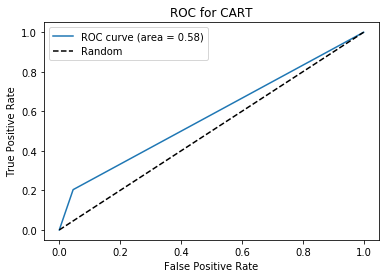

In [12]:
# Plot the ROC curve

def plot_roc(Y_test,Y_pred):
    fpr, tpr, _ = roc_curve(Y_test,Y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC for CART")
    plt.legend(loc="best")
    plt.show()
plot_roc(Y_test,prediction)

In [13]:
# random forest
from sklearn.ensemble import RandomForestClassifier
model_random = RandomForestClassifier(random_state=42)
param_grid = {
             'min_samples_split': [2,4,6,8],
             'criterion':["gini","entropy"],
             'max_features':["auto", "sqrt", "log2"],
              'max_depth':[6,8,10,20],
              'min_samples_leaf':[1,2,4,6],
             'max_leaf_nodes':[10,50]}  
random_grid =  GridSearchCV(model_random,param_grid,scoring="roc_auc", cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
random_grid.fit(X_train,Y_train)
model_random = random_grid.best_estimator_
tree_error_rate =1 - model_random.score(X_test,Y_test)
tree_error_rate

Fitting 10 folds for each of 768 candidates, totalling 7680 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 2420 tasks      | elapsed:    6.6s
[Parallel(n_jobs=6)]: Done 6420 tasks      | elapsed:   18.2s
[Parallel(n_jobs=6)]: Done 7680 out of 7680 | elapsed:   21.9s finished
C:\Users\dong\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.5

In [14]:
model_random.score(X_train, Y_train)

0.896551724137931

In [15]:
new_prediction = model_random.predict(X_test)
print(confusion_matrix(Y_test, new_prediction))

[[36  8]
 [41 13]]


In [16]:
print(classification_report(Y_test, new_prediction))

              precision    recall  f1-score   support

           0       0.47      0.82      0.60        44
           1       0.62      0.24      0.35        54

    accuracy                           0.50        98
   macro avg       0.54      0.53      0.47        98
weighted avg       0.55      0.50      0.46        98



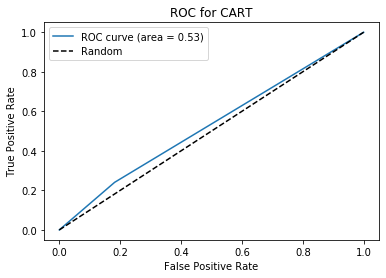

In [17]:
plot_roc(Y_test,new_prediction)

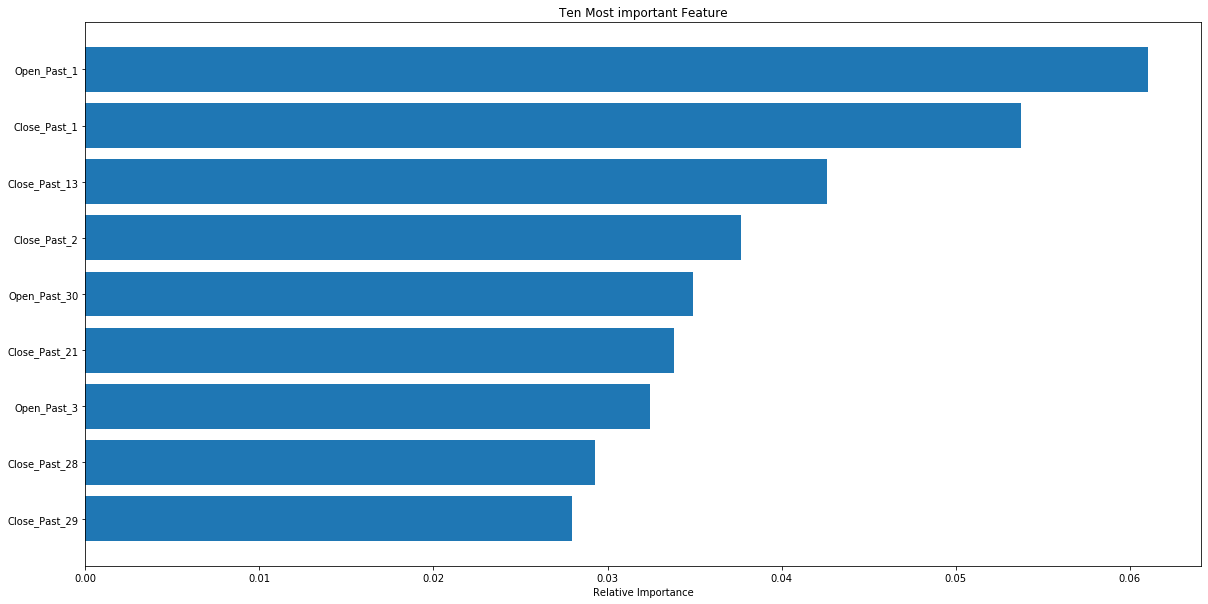

In [18]:
# new chart
features=btc.drop(['MonthTrend'],axis=1).columns
%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 10
sorted_id = np.argsort(model_random.feature_importances_)
sorted_id = sorted_id[-9:]
padding = np.arange(len(sorted_id))+10
plt.barh(padding, model_random.feature_importances_[sorted_id], align='center')
plt.yticks(padding, features[sorted_id])
plt.xlabel("Relative Importance")
plt.title("Ten Most important Feature")
plt.show()

In [19]:
# linear svm
from sklearn.svm import LinearSVC
model_svm = LinearSVC(random_state=42)
param_grid = {
             'C': [1,2,4,6,8,10],
             'loss':["hinge","squared_hinge"],
             'fit_intercept':[True,False],
              'class_weight':["balanced",None]}  
svm_grid =  GridSearchCV(model_svm,param_grid,scoring="roc_auc", cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
svm_grid.fit(X_train,Y_train)
model_svm = svm_grid.best_estimator_
svm_error_rate =1 - model_svm.score(X_test,Y_test)
svm_error_rate

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 480 out of 480 | elapsed:    1.0s finished
C:\Users\dong\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.09183673469387754

In [20]:
model_svm.score(X_train, Y_train)

0.9956896551724138

In [21]:
svm_prediction = model_svm.predict(X_test)
print(confusion_matrix(Y_test, svm_prediction))

[[42  2]
 [ 7 47]]


In [22]:
print(classification_report(Y_test, svm_prediction))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90        44
           1       0.96      0.87      0.91        54

    accuracy                           0.91        98
   macro avg       0.91      0.91      0.91        98
weighted avg       0.91      0.91      0.91        98



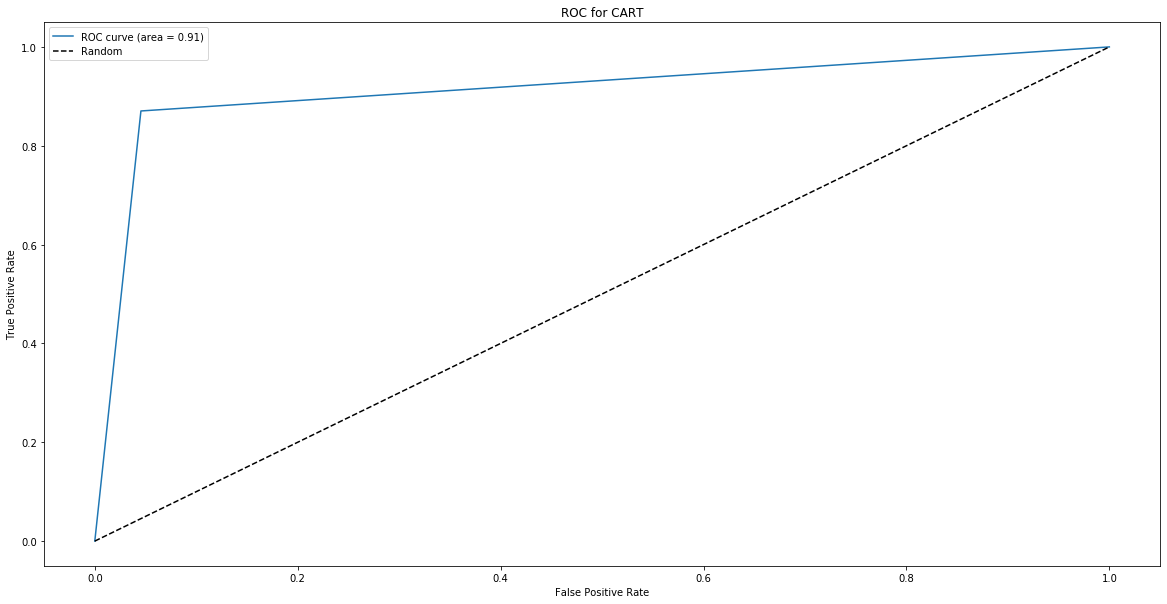

In [23]:
plot_roc(Y_test,svm_prediction)

In [24]:
# logistic regression
from sklearn.linear_model import LogisticRegression
model_regression = LogisticRegression()
param_grid = {
             'C': [1,2,4,6,8,10],
             'penalty':["l1", "l2"],
             'fit_intercept':[True,False],
              'class_weight':["balanced",None],
              'warm_start':[True,False]}  
regression_grid =  GridSearchCV(model_regression,param_grid,scoring="roc_auc", cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
regression_grid.fit(X_train,Y_train)
model_regresssion= regression_grid.best_estimator_
regression_error_rate =1 - model_regresssion.score(X_test,Y_test)
regression_error_rate

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 104 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 960 out of 960 | elapsed:    2.8s finished
C:\Users\dong\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.05102040816326525

In [25]:
regression_prediction = model_regresssion.predict(X_test)
print(confusion_matrix(Y_test, regression_prediction))

[[43  1]
 [ 4 50]]


In [26]:
print(classification_report(Y_test, regression_prediction))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95        44
           1       0.98      0.93      0.95        54

    accuracy                           0.95        98
   macro avg       0.95      0.95      0.95        98
weighted avg       0.95      0.95      0.95        98



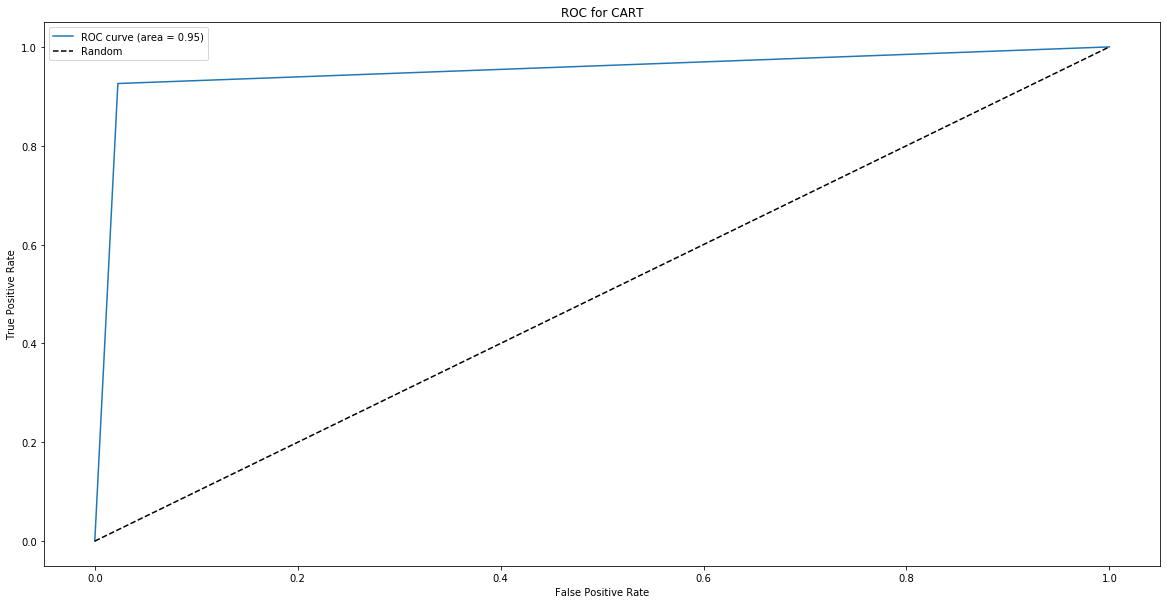

In [27]:
plot_roc(Y_test,regression_prediction)

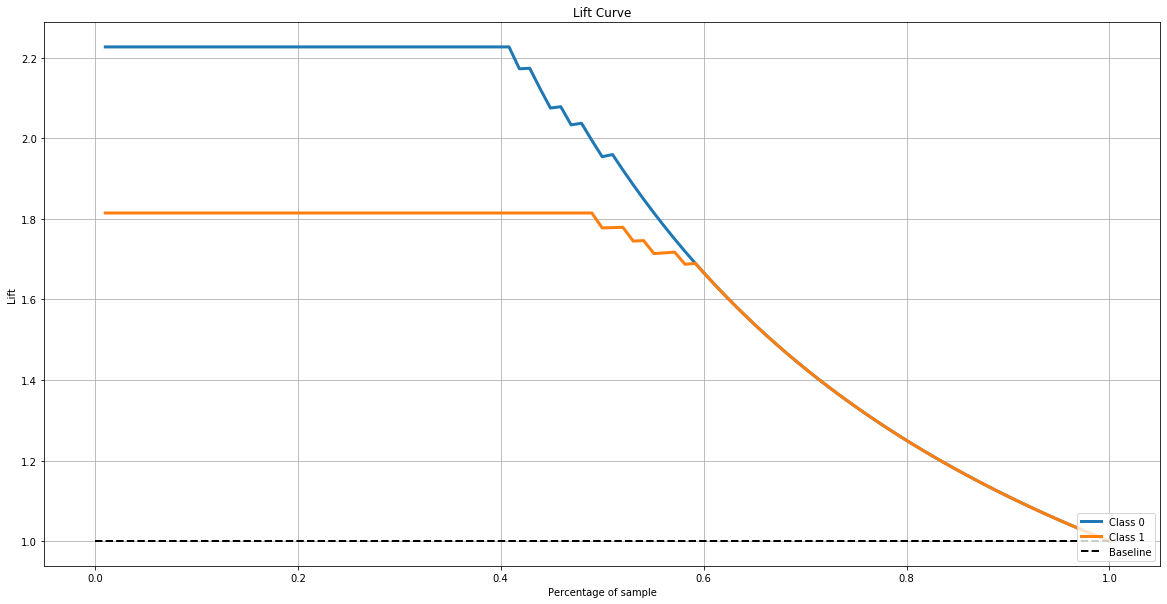

In [35]:
import scikitplot as skplt
regression_probas = model_regresssion.predict_proba(X_test)
skplt.metrics.plot_lift_curve(Y_test,regression_probas)
plt.show()

In [ ]:
# install tensorflow in virtual enviroment locally or use google colab
# Please read this line at least.Basic model frame tuning may needed. I reached 0.7347 test accuracy for old dataset.
import tensorflow as tf
# Nerual network layer by layer. The input shape(...,62) may vary if new added
NN_model = tf.keras.models.Sequential()
NN_model.add(tf.keras.layers.Dense(units=128,activation="relu",input_dim=X_train.shape[1])) 
# dropout exist for preventing overfitting. 
NN_model.add(tf.keras.layers.Dropout(0.2))
NN_model.add(tf.keras.layers.Dense(units=256,activation="relu"))
NN_model.add(tf.keras.layers.Dropout(0.2)) 
NN_model.add(tf.keras.layers.Dense(units=256,activation="relu")) 
# please do not change this line. sigmoid function is a must for binary classification
NN_model.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
# you can play with this line
NN_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy']) 

In [ ]:
# a basic summary of model
NN_model.summary()

In [ ]:
# I added early stop here.
earlyStopping=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=0, mode='min')
NN_model.fit(x=X_train,y=Y_train,batch_size=30,epochs=50,callbacks=[earlyStopping])

In [ ]:
test_loss, test_accuracy = NN_model.evaluate(X_test, Y_test)

In [ ]:
NN_prediction = NN_model.predict_classes(X_test)
print(confusion_matrix(Y_test,NN_prediction))

In [ ]:
print(classification_report(Y_test,NN_prediction))

In [ ]:
plot_roc(Y_test,NN_prediction)